# La Guajira wind energy analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import Image

In [2]:
# Load datasets and inspect first rows
wind_speed = pd.read_csv("./datasets/windGuajira2019.csv", skiprows= 3)
air_density = pd.read_csv("./datasets/airDensityGuajira2019.csv", skiprows= 3)

In [22]:
# Inspect wind speed dataframe
print(wind_speed.head(), "\n\n")
print(wind_speed.info())

               time        local_time  electricity  wind_speed
0  2019-01-01 00:00  2018-12-31 19:00        0.952      13.742
1  2019-01-01 01:00  2018-12-31 20:00        0.953      13.783
2  2019-01-01 02:00  2018-12-31 21:00        0.946      13.515
3  2019-01-01 03:00  2018-12-31 22:00        0.940      13.327
4  2019-01-01 04:00  2018-12-31 23:00        0.941      13.341 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8760 non-null   object 
 1   local_time   8760 non-null   object 
 2   electricity  8760 non-null   float64
 3   wind_speed   8760 non-null   float64
dtypes: float64(2), object(2)
memory usage: 273.9+ KB
None


In [23]:
# Inspect air density dataframe
print(air_density.head(), "\n\n")
print(air_density.info())

               time        local_time   rhoa
0  2019-01-01 00:00  2018-12-31 19:00  1.167
1  2019-01-01 01:00  2018-12-31 20:00  1.168
2  2019-01-01 02:00  2018-12-31 21:00  1.169
3  2019-01-01 03:00  2018-12-31 22:00  1.169
4  2019-01-01 04:00  2018-12-31 23:00  1.169 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        8760 non-null   object 
 1   local_time  8760 non-null   object 
 2   rhoa        8760 non-null   float64
dtypes: float64(1), object(2)
memory usage: 205.4+ KB
None


Both dataframes contain the pair of columns `time` and `local_time`, which containing datetime information currently stored as object type, need to be coerced into the appropriate data type. However, as these dataframes contain information for the same geographical area and for the same timespan, we can join them and dispense with repeated columns.

In [3]:
# Create a copy of the dataframe
wind_speed_copy = wind_speed.copy()

# Remove time and electricity columns
wind_speed_copy.drop(["time", "electricity"], axis = 1 ,inplace = True)

# Convert local_time to datetime data type
wind_speed_copy["local_time"] = pd.to_datetime(wind_speed_copy["local_time"])

# Set local_time column as index
wind_speed_copy.set_index("local_time", inplace= True)

# Rename wind_speed column
wind_speed_copy.rename(columns= {'wind_speed': 'wind_speed_m/s'}, inplace= True)

# Print first 5 rows
wind_speed_copy.head()

,wind_speed_m/s
local_time,
2018-12-31 19:00:00,13.742
2018-12-31 20:00:00,13.783
2018-12-31 21:00:00,13.515
2018-12-31 22:00:00,13.327
2018-12-31 23:00:00,13.341


In [4]:

# Create a copy of the dataframe
air_density_copy = air_density.copy()

# Remove time column
air_density_copy.drop("time", axis= 1, inplace= True)

# Convert local_time column to datetime data type
air_density_copy["local_time"] = pd.to_datetime(air_density_copy["local_time"])

# Set local_time as index
air_density_copy.set_index("local_time", inplace= True)

# Rename rhoa column to "air_density"
air_density_copy.rename(columns = {"rhoa": "air_density_kg/m3"}, inplace = True)

# Print first 5 rows
air_density_copy.head()

,air_density_kg/m3
local_time,
2018-12-31 19:00:00,1.167
2018-12-31 20:00:00,1.168
2018-12-31 21:00:00,1.169
2018-12-31 22:00:00,1.169
2018-12-31 23:00:00,1.169


In [10]:
# Inspect both new dataframes
print(wind_speed_copy.info(), "\n\n")
print(air_density_copy.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-12-31 19:00:00 to 2019-12-31 18:00:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wind_speed_m/s  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB
None 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-12-31 19:00:00 to 2019-12-31 18:00:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   air_density_kg/m3  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB
None


In [19]:
# Null values in both datasets
print((
    wind_speed_copy
    .isnull()
    .sum()
), '\n')

print((
    air_density_copy
    .isnull()
    .sum()
))

wind_speed_m/s    0
dtype: int64 

air_density_kg/m3    0
dtype: int64


In [5]:
# Time frame of both dataframes
print("Wind speed data:" ,(
    np.min(wind_speed_copy.index),
    np.max(wind_speed_copy.index)
), "\n")

print("Air density data:" ,(
    np.min(air_density_copy.index),
    np.max(air_density_copy.index)
))

Wind speed data: (Timestamp('2018-12-31 19:00:00'), Timestamp('2019-12-31 18:00:00')) 

Air density data: (Timestamp('2018-12-31 19:00:00'), Timestamp('2019-12-31 18:00:00'))


In [42]:
# Check frequency in both dataframes
print(
    f"""
        Wind speed data frequency: {pd.infer_freq(wind_speed_copy.index)} \n
        Air density data frequency: {pd.infer_freq(air_density_copy.index)} \n
    """
)



        Wind speed data frequency: H 

        Air density data frequency: H 

    


After making sure both dataframes cover the same time span and have the same frequency, it is safe to join these into a single dataframe.

In [6]:
# Join dataframes
wind_df = wind_speed_copy.join(air_density_copy)
wind_df.head()

,wind_speed_m/s,air_density_kg/m3
local_time,,
2018-12-31 19:00:00,13.742,1.167
2018-12-31 20:00:00,13.783,1.168
2018-12-31 21:00:00,13.515,1.169
2018-12-31 22:00:00,13.327,1.169
2018-12-31 23:00:00,13.341,1.169


In [96]:
wind_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-12-31 19:00:00 to 2019-12-31 18:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_speed_m/s     8760 non-null   float64
 1   air_density_kg/m3  8760 non-null   float64
dtypes: float64(2)
memory usage: 205.3 KB


Dataset spread measures:

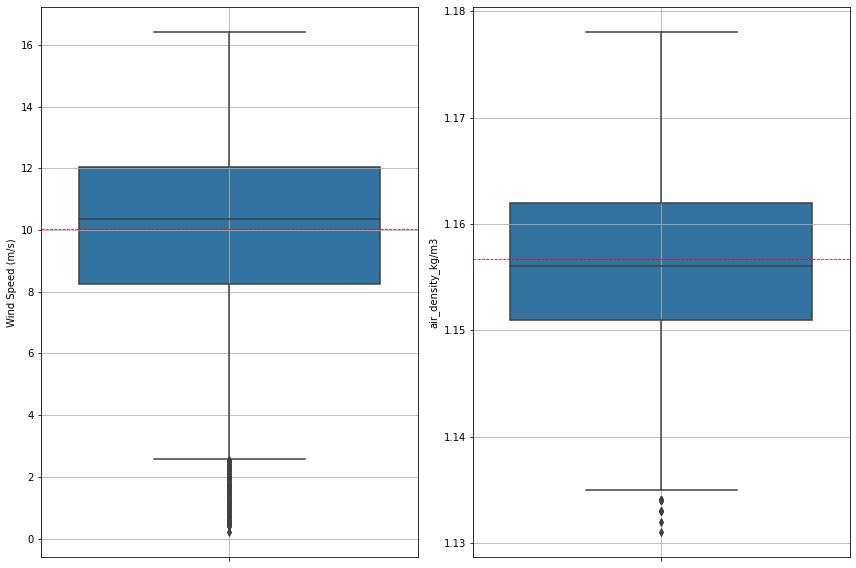

In [7]:
fix, ax = plt.subplots(1, 2, figsize= (12,8))

sns.boxplot(y= wind_df['wind_speed_m/s'], ax= ax[0])
ax[0].axhline(y=wind_df["wind_speed_m/s"].mean(),
              linewidth=0.8, 
              color="r", 
              linestyle="dashed")
ax[0].set_ylabel("Wind Speed (m/s)")
ax[0].grid(linewidth=0.8)

sns.boxplot(y= wind_df['air_density_kg/m3'], ax= ax[1])
ax[1].axhline(y= wind_df['air_density_kg/m3'].mean(),
              linewidth= 0.8,
              color= 'red',
              linestyle= 'dashed')
ax[1].grid(linewidth= 0.8)

plt.tight_layout()
plt.show()

In [123]:
pd.options.display.float_format = "{:,.2f}".format
wind_df.describe()

,wind_speed_m/s,air_density_kg/m3
count,"8,760.00","8,760.00"
mean,10.02,1.16
std,2.70,0.01
min,0.20,1.13
25%,8.25,1.15
50%,10.36,1.16
75%,12.05,1.16
max,16.40,1.18


In [7]:
print(f"\nVariance: \n\n{wind_df.var()}\n")

print(f"Correlation: {wind_df['wind_speed_m/s'].corr(wind_df['air_density_kg/m3'])} \n")


Variance: 

wind_speed_m/s       7.305329
air_density_kg/m3    0.000071
dtype: float64

Correlation: 0.23607921275863908 



  
Wind speed data is relatively widely spread, with values ranging from $0.20 \: m/s$ to $16.40 \: m/s$, including some observations considered outliers, which we will identify shortly. In contrast, the air density data shows a moderate spread, varying within approximately $0.05 \: kg/m^3$, with an average of $1.15 \: kg/m^3$, value that will be used to calculate the power generated by the wind turbines.

In [8]:
# Outliers identification
q1 = wind_df.quantile(0.25)
q3 = wind_df.quantile(0.75)
iqr = q3 - q1
lwr = q1 - 1.5 * iqr


wind_speed_outliers = wind_df[wind_df['wind_speed_m/s'] < lwr[0]][['wind_speed_m/s']]
wind_speed_outliers = pd.merge(wind_speed_outliers, wind_df['air_density_kg/m3'], how= 'left', left_index= True, right_index= True)
wind_speed_outliers

,wind_speed_m/s,air_density_kg/m3
local_time,,
2019-09-08 14:00:00,2.071,1.135
2019-09-18 05:00:00,2.032,1.152
2019-09-18 06:00:00,1.570,1.153
2019-09-18 07:00:00,1.234,1.152
2019-09-18 08:00:00,0.807,1.150
...,...,...
2019-11-18 11:00:00,2.004,1.151
2019-11-18 12:00:00,2.246,1.148
2019-11-19 09:00:00,2.252,1.157


In [9]:
pd.options.display.float_format = "{:,.2f}".format
wind_speed_outliers.describe()

,wind_speed_m/s,air_density_kg/m3
count,97.00,97.00
mean,1.54,1.15
std,0.64,0.01
min,0.20,1.14
25%,0.98,1.15
50%,1.63,1.15
75%,2.07,1.16
max,2.55,1.16


In [46]:
# Find out date and time of the lowest wind speed observation
wind_speed_outliers[wind_speed_outliers['wind_speed_m/s'] == np.min(wind_speed_outliers['wind_speed_m/s'])]

,wind_speed_m/s,air_density_kg/m3
local_time,,
2019-09-25 08:00:00,0.20,1.16


In [47]:
wind_df.loc['2019-09-25']

,wind_speed_m/s,air_density_kg/m3
local_time,,
2019-09-25 00:00:00,4.26,1.15
2019-09-25 01:00:00,3.94,1.15
2019-09-25 02:00:00,3.51,1.15
2019-09-25 03:00:00,3.07,1.15
2019-09-25 04:00:00,2.67,1.16
2019-09-25 05:00:00,2.10,1.16
2019-09-25 06:00:00,1.63,1.16
2019-09-25 07:00:00,0.90,1.16
2019-09-25 08:00:00,0.20,1.16


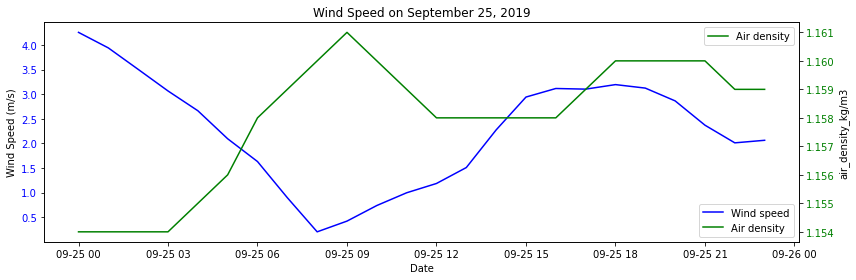

In [48]:
# PLot wind speed in the day of 

fig, ax1 = plt.subplots(figsize= (12,4))
line1=sns.lineplot(data= wind_df.loc['2019-09-25'],
             x = wind_df.loc['2019-09-25'].index,
             y = 'wind_speed_m/s', 
             color= 'blue', ax= ax1,
             label= 'Wind speed')
plt.title("Wind Speed on September 25, 2019")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
line2=sns.lineplot(data= wind_df.loc['2019-09-25'],
             x = wind_df.loc['2019-09-25'].index,
             y = 'air_density_kg/m3', 
             color= 'green', ax= ax2,
             label= 'Air density')
ax2.tick_params(axis='y', labelcolor='green')

lines = line1.get_lines() + line2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')  # you can change loc to 'upper right' or 'lower center'

plt.tight_layout()
plt.show()

Examining these outliers, they are not likely to be severe anomalies given the nature of the data. Wind speed is a highly variable phenomenon, with readings that can change rapidly, reflecting natural fluctuations rather than errors. The lowest values, around 0.2 m/s, could correspond to very calm wind conditions. Conveniently, the air density readings at the same times show a behaviour that correlates to some extent. With this low wind speed and high air density happening in the morning, it can be inferred that conditions might have been dominated by a cold, stable, high-pressure air mass, resulting in high air density and very little wind movement.

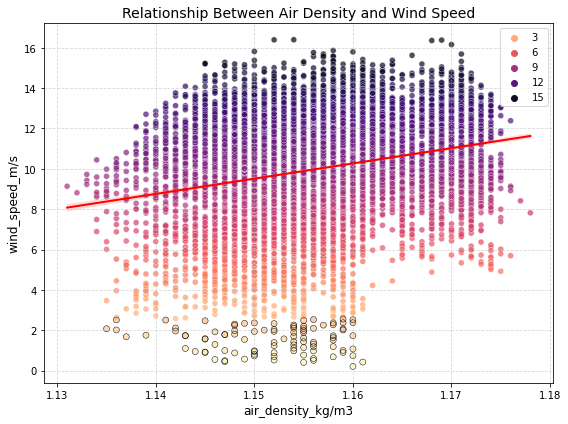

In [65]:
fig, ax = plt.subplots(figsize= (8,6))

sns.scatterplot(data= wind_df,
                x= 'air_density_kg/m3',
                y= 'wind_speed_m/s',
                hue= 'wind_speed_m/s', palette= 'magma_r',
                alpha= 0.7)
ax.set_title("Relationship Between Air Density and Wind Speed", fontsize=14)
ax.set_xlabel("Air Density (kg/m³)", fontsize=12)
ax.set_ylabel("Wind Speed (m/s)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Wind Speed [m/s]", loc='lower right')

sns.scatterplot(data= wind_speed_outliers,
                x = 'air_density_kg/m3',
                y = 'wind_speed_m/s',
                facecolor= 'none', alpha=1, 
                edgecolor= 'black')
sns.regplot(
    data=wind_df,
    x='air_density_kg/m3',
    y='wind_speed_m/s',
    scatter=False,
    ax=ax,
    color='red',
    line_kws={'linewidth': 2}
)


plt.tight_layout()
plt.show()

However, when comparing air density to wind speed, we find that the correlation is very low, almost nonexistent. In this context, it is important to keep in mind that, as mentioned earlier, many other factors influence both wind speed and air density. Wind speed can vary according to pressure and temperature gradients, while air density is influenced by humidity and temperature, among other factors. This explains why the 'outliers' are, in fact, normal readings, with a distribution that does not show a clear pattern but rather the complex nature of wind phenomena.

Now, considering these apparent outliers now considered as correct measurements under specific weather conditions, we can move on to the analysis of power generation from wind.

The power generated by wind turbines can be calculated with the formula:  

$$ 
P = \frac{1}{2} \times Air \: Density \times Rotor Swept Area \times Wind \: Speed^3 \times Efficiency
$$

Given an efficiency coefficient $ec = 0.4$, a rotor swept diameter $ \varnothing = 60m$, and the air density mean and wind speed median values, we can calculate the electric power generated per wind turbine. 
To begin with, let's work out the rotor swept area from the known diameter value.

In [10]:
d = 60 # rotor swept diameter value

rs_area = np.pi * (d/2)**2

print(f"Rotor Swept Area = {rs_area} squared meters")

Rotor Swept Area = 2827.4333882308138 squared meters


With this rotor-swept area, let's calculate the power generated from each turbine, considering the formula:  

$$
power=\: \frac{1}{2} \times Air \: Density \times Rotor Swept Area \times Wind \: Speed^3
$$

Using the corresponding mean values for air density and wind speed.

In [11]:
air_density_mean = wind_df["air_density_kg/m3"].mean()
wind_speed_p50 = wind_df["wind_speed_m/s"].median()
ec = 0.4  # Efficiency coefficient

def power_gen(air_den, area, wind_s, eff_coef):
    """Work out wind turbines power generation capacity in MW"""
    return round((0.5* air_den * area * wind_s**3 * eff_coef) / 1e6, 3)


In [12]:
mean_power_gen = power_gen(air_density_mean, rs_area, wind_speed_p50, ec)

print(f"Estimated mean power generation capacity: {mean_power_gen} MW")

Estimated mean power generation capacity: 0.727 MW


That is, considering the average values of wind speed and air density, and a turbine with an efficiency coefficient of 0.4, the power generation amounts to approximately 0.727 MW.
Now, let's calculate the power generation using the 25th and 75th percentile values of wind speed observations.

In [76]:
# Repeating the process with the 25th and 75th percentiles of wind speed.
wind_speed_p25 = np.quantile(wind_df["wind_speed_m/s"], 0.25)
wind_speed_p75 = np.quantile(wind_df["wind_speed_m/s"], 0.75)

power_gen_p25 = power_gen(air_density_mean, rs_area, wind_speed_p25, ec)
power_gen_p75 = power_gen(air_density_mean, rs_area, wind_speed_p75, ec)

print(f"25% percentile estimated power generation capacity: {power_gen_p25} MW")
print(f"50% percentile estimated power generation capacity: {mean_power_gen } MW")
print(f"75% percentile estimated power generation capacity: {power_gen_p75} MW")


25% percentile estimated power generation capacity: 0.368 MW
50% percentile estimated power generation capacity: 0.727 MW
75% percentile estimated power generation capacity: 1.145 MW


The turbine manufacturer specified a power generation capacity of 1.3 MW, which was not reached in the calculations based on the wind speed and air density data.  
Let's now calculate the power generation for the whole dataset, and check out its distribution.

In [73]:
pd.options.display.float_format = "{:,.3f}".format

wind_df_copy = wind_df.copy()
wind_df_copy["power_gen_mw"] = (0.5 * wind_df_copy["air_density_kg/m3"] * rs_area * wind_df_copy["wind_speed_m/s"]**3 * ec) / 1000000

wind_df_copy.head()

,wind_speed_m/s,air_density_kg/m3,power_gen_mw
local_time,,,
2018-12-31 19:00:00,13.742,1.167,1.713
2018-12-31 20:00:00,13.783,1.168,1.729
2018-12-31 21:00:00,13.515,1.169,1.632
2018-12-31 22:00:00,13.327,1.169,1.565
2018-12-31 23:00:00,13.341,1.169,1.570


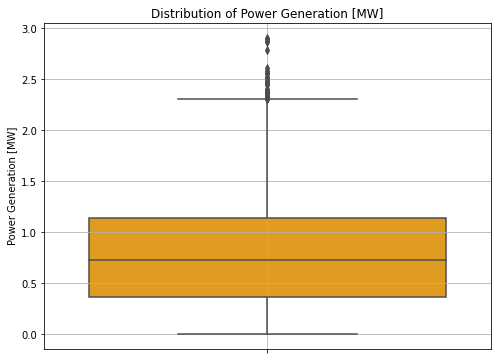

In [92]:
fig, ax = plt.subplots(figsize = (8,6))

sns.boxplot(data= wind_df_copy,
            y = 'power_gen_mw',
            color= 'orange')
ax.set_ylabel("Power Generation [MW]")
ax.set_title("Distribution of Power Generation [MW]")
ax.grid(linewidth= 0.8)

plt.show()

In [75]:
wind_df_copy[['power_gen_mw']].describe()

,power_gen_mw
count,"8,760.000"
mean,0.794
std,0.514
min,0.000
25%,0.368
50%,0.729
75%,1.144
max,2.907


This calculation applies to a single wind turbine. Now, let's assume that 15 wind turbines are installed in the wind farm.

In [77]:
print(f"25% percentile estimated total power generation capacity: {power_gen_p25 * 15} MW")
print(f"50% percentile estimated total power generation capacity: {mean_power_gen * 15} MW")
print(f"75% percentile estimated total power generation capacity: {power_gen_p75 * 15} MW")

25% percentile estimated total power generation capacity: 5.52 MW
50% percentile estimated total power generation capacity: 10.905 MW
75% percentile estimated total power generation capacity: 17.175 MW


According to official data, the wind farm has an installed capacity of 19.5 MW. So, this represent how much the wind farm’s actual production falls below its installed capacity of 19.5 MW. Showing that 75% of the observations have a generation level at least 12.47% below the installed capacity, the median shortfall is 44.38%, and in the lowest-performing quartile production drops more than 71.91% below capacity, illustrating a consistent underperformance compared to the expected output.

In [93]:
pd.options.display.float_format = "{:,.2f}".format

p25_ag = round((((power_gen_p25 * 15) * 8760) / 1000),2)
p50_ag = round((((mean_power_gen * 15) * 8760) / 1000),2)
p75_ag = round((((power_gen_p75 * 15) * 8760) / 1000),2)

print(f"25% percentile annual estimated total power generation capacity: {p25_ag} GW")
print(f"50% percentile annual estimated total power generation capacity: {p50_ag} GW")
print(f"75% percentile annual estimated total power generation capacity: {p75_ag} GW")

25% percentile annual estimated total power generation capacity: 48.36 GW
50% percentile annual estimated total power generation capacity: 95.53 GW
75% percentile annual estimated total power generation capacity: 150.45 GW


Considering the power generation of $1300 \:kW$ per wind turbine, 15 wind turbines would generate $19.5 \:MW$ per day, which amounts to $170.82 \:GWh$ per year. However, according to the previous calculations, 75% of the observations reach an annual total power generation of up to $150.45\: GWh$, corresponding to roughly 12% less than the specified as installed capacity.  

After calculating the power generation using the mean values of air density and wind speed, let's now recalculate it using the data gathered from Renewable Ninja website.

In [14]:
wind_speed2 = wind_speed.copy()
wind_speed2.drop(['local_time', 'electricity'], axis= 1, inplace= True)
wind_speed2.head()

,time,wind_speed
0,2019-01-01 00:00,13.74
1,2019-01-01 01:00,13.78
2,2019-01-01 02:00,13.52
3,2019-01-01 03:00,13.33
4,2019-01-01 04:00,13.34


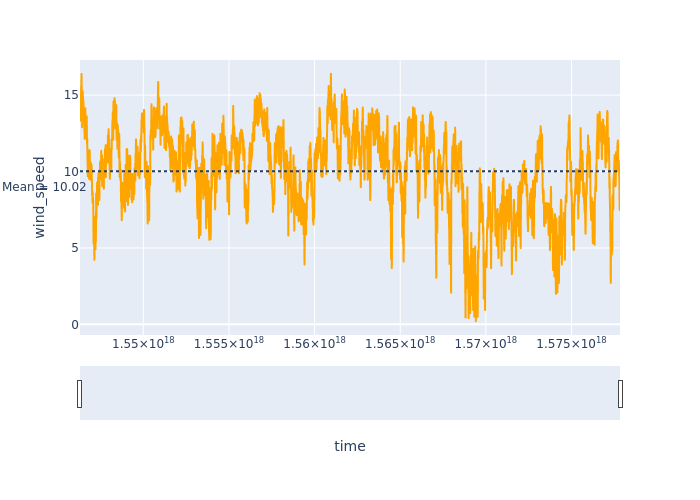

In [124]:
px.defaults.width = 1000
px.defaults.height = 400

fig = px.line(wind_speed2, x= wind_speed2.index, y= 'wind_speed', color_discrete_sequence= ['orange'])
fig.add_hline(y = wind_speed2['wind_speed'].mean(), line_dash= 'dot')
fig.add_annotation(x = '2019-01-03', y = wind_speed2['wind_speed'].mean() - 1, text= f"Mean = {round(wind_speed2['wind_speed'].mean(),2)}", showarrow= False)

fig.update_xaxes(rangeslider_visible= True)

fig.show()

fig.write_image("imgs/wind_speed.png")
Image("imgs/wind_speed.png")

Let's now break down this wind speed time series into its trend, seasonal, and residual components in order to try the understand the underlying patterns in the data.

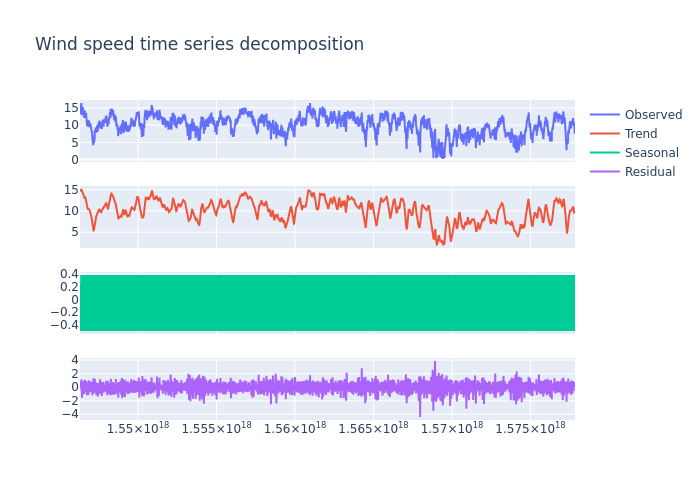

In [122]:
# Use seasonal_decompose from statsmodels.tsa.seasonal submodule to break down the time series
# into its constituent components: trend, seasonal, and residual
decomposition = seasonal_decompose(wind_speed2['wind_speed'], model= 'additive', period= 24)

fig = make_subplots(rows= 4, cols= 1, shared_xaxes= True)
fig.add_trace(go.Scatter(x= wind_speed2.index, y= decomposition.observed, name= 'Observed'), row= 1, col= 1)
fig.add_trace(go.Scatter(x= wind_speed2.index, y= decomposition.trend, name= 'Trend'), row= 2, col= 1)
fig.add_trace(go.Scatter(x= wind_speed2.index, y= decomposition.seasonal, name= 'Seasonal'), row= 3, col= 1)
fig.add_trace(go.Scatter(x= wind_speed2.index, y= decomposition.resid, name= 'Residual'), row= 4, col= 1)

fig.update_layout(height= 800, width= 900, title= 'Wind speed time series decomposition')
fig.show()

fig.write_image("imgs/decomposition.png")
Image("imgs/decomposition.png")

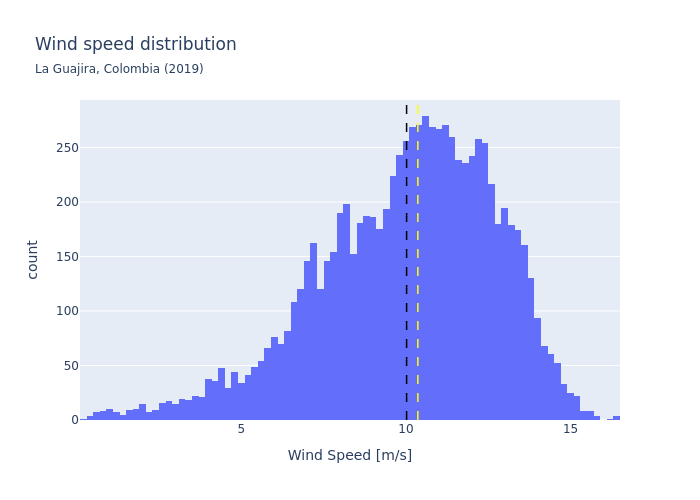

In [120]:
px.defaults.height = 400
px.defaults.width = 800

fig = px.histogram(wind_speed2, 
                   x= 'wind_speed',
                   nbins= 100,
                   title= 'Wind speed distribution', subtitle= 'La Guajira, Colombia (2019)',
                   labels= {'wind_speed': 'Wind Speed [m/s]'}
                )
fig.add_vline(x= np.mean(wind_speed2['wind_speed']), line_width= 1.5, line_dash= 'dash', line_color= 'black')
fig.add_vline(x= np.median(wind_speed2['wind_speed']), line_width= 1.5, line_dash= 'dash', line_color= 'yellow')

fig.show()


fig.write_image("imgs/wind_speed_histogram.png")
Image("imgs/wind_speed_histogram.png")

Wind speed ditribution according to the hour

In [ ]:
wind_speed2['time'] = pd.to_datetime(wind_speed2['time'])
wind_speed2.set_index('time', inplace= True)

In [98]:
wind_speed2['month'] = wind_speed2.index.month
wind_speed2['day'] = wind_speed2.index.day
wind_speed2['hour'] = wind_speed2.index.hour

wind_speed2.head()

,wind_speed,month,day,hour
time,,,,
2019-01-01 00:00:00,13.74,1,1,0
2019-01-01 01:00:00,13.78,1,1,1
2019-01-01 02:00:00,13.52,1,1,2
2019-01-01 03:00:00,13.33,1,1,3
2019-01-01 04:00:00,13.34,1,1,4


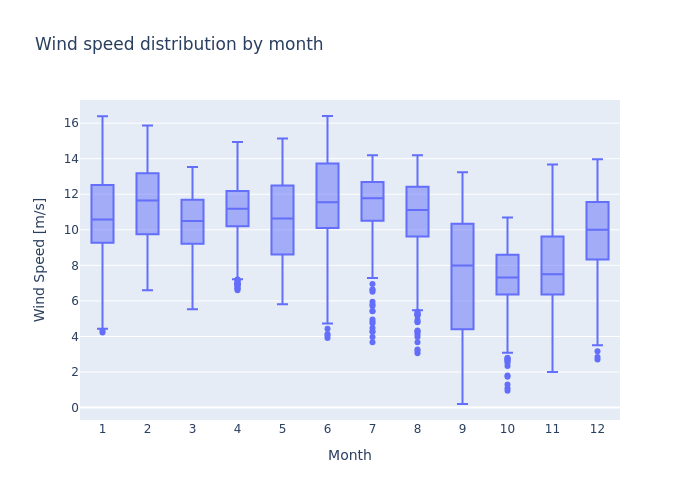

In [126]:
fig = px.box(data_frame= wind_speed2,
             x= 'month',
             y= 'wind_speed', 
             title= 'Wind speed distribution by month',
             labels= {'wind_speed': 'Wind Speed [m/s]',
                      'month': 'Month'})
fig.update_xaxes(tickmode= 'linear')

fig.show()

fig.write_image('imgs/wind_speed_month.png')
Image('imgs/wind_speed_month.png')

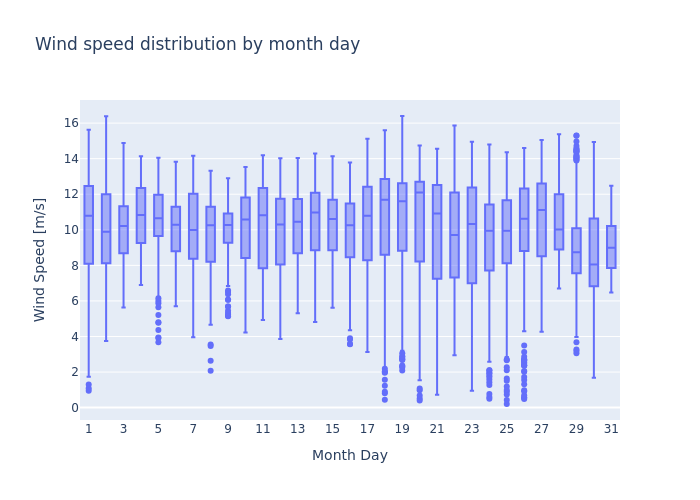

In [127]:
px.defaults.width = 900
px.defaults.height = 400


fig = px.box(data_frame= wind_speed2,
       x = 'day',
       y = 'wind_speed',
       title= 'Wind speed distribution by month day',
       labels= {'wind_speed': 'Wind Speed [m/s]',
                'day': 'Month Day'} )
fig.update_xaxes(tickmode = 'array', tickvals= list(range(1,32,2)))

fig.show()

fig.write_image('imgs/wind_speed_day.png')
Image('imgs/wind_speed_day.png')

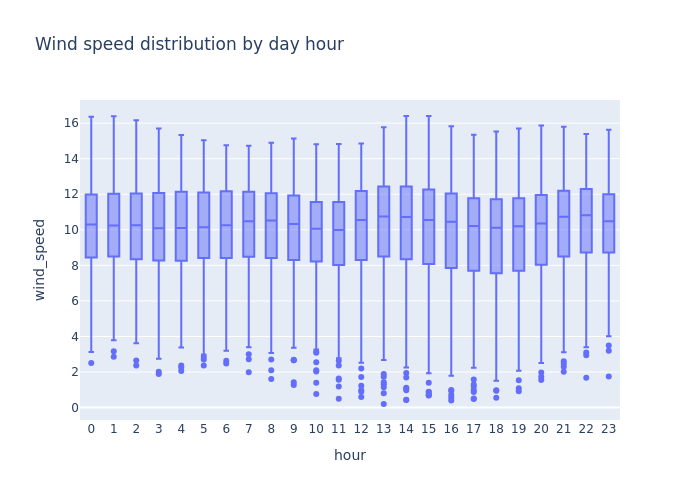

In [128]:
fig = px.box(data_frame= wind_speed2,
             x = 'hour',
             y = 'wind_speed',
             title= 'Wind speed distribution by day hour')
fig.update_xaxes(tickmode= 'linear')

fig.show()

fig.write_image('imgs/wind_speed_hour.png')
Image('imgs/wind_speed_hour.png')